In [10]:
#!pip install google-cloud-bigquery

In [9]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

from pprint import pprint
from google.cloud import bigquery

In [2]:
bq_project_id = "okta-ga-rollup"
client = bigquery.Client(project=bq_project_id)
timeout_seconds = 300

In [11]:
def storage():
    bq_client = bigquery.Client(project=bq_project_id)
    query = f"""
    def storage():
    bq_client = bigquery.Client(project=bq_project_id)
    query = f"""
    SELECT 
          table_schema,
          table_name,
          total_rows,
          -- Compression analysis
          active_logical_bytes/pow(1024,3) as active_logical_gb,
          active_physical_bytes/pow(1024,3) as active_physical_gb,
          ROUND(active_logical_bytes/NULLIF(active_physical_bytes,0),2) as compression_ratio,
          FORMAT("%.2f%%", (1 - active_physical_bytes/NULLIF(active_logical_bytes,0)) * 100) as compression_savings,
          -- Storage versions analysis
          time_travel_physical_bytes/pow(1024,3) as time_travel_gb,
          fail_safe_physical_bytes/pow(1024,3) as failsafe_gb,
          -- Total storage impact
          total_physical_bytes/pow(1024,3) as total_physical_gb,
          -- Last modified to check update frequency
          storage_last_modified_time,
          -- Partition info for incremental analysis
          total_partitions
        FROM `okta-ga-rollup.region-us.INFORMATION_SCHEMA.TABLE_STORAGE`
        WHERE 
          -- Filter for actual tables
          table_type = 'BASE TABLE'
          -- Optional: Filter specific schema
          -- AND table_schema = 'your_schema'
        ORDER BY active_logical_bytes DESC
        LIMIT 20;
    """
    df = bq_client.query(query).to_dataframe()
    return df
    """
    df = bq_client.query(query).to_dataframe()
    return df
    

In [12]:
df = storage()

In [16]:
df.columns

Index(['table_schema', 'table_name', 'total_rows', 'active_logical_gb',
       'active_physical_gb', 'compression_ratio', 'compression_savings',
       'time_travel_gb', 'failsafe_gb', 'total_physical_gb',
       'storage_last_modified_time', 'total_partitions'],
      dtype='object')

In [25]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Set float format
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap wide displays


# Calculate storage costs
def analyze_storage_costs(df):
    # Calculate costs
    df['logical_monthly_cost'] = df['active_logical_gb'] * 0.02
    df['physical_monthly_cost'] = (
        df['active_physical_gb'] + 
        (df['time_travel_gb'] * 2/7) +
        df['failsafe_gb']
    ) * 0.04

    # Calculate potential savings
    df['potential_savings_usd'] = df['logical_monthly_cost'] - df['physical_monthly_cost']
    df['savings_percentage'] = (df['potential_savings_usd'] / df['logical_monthly_cost']) * 100

    return df

# Analyze costs
analysis = analyze_storage_costs(df)

# Create main analysis DataFrame
main_analysis = analysis[['table_schema', 
                         'table_name',
                         'active_logical_gb',
                         'active_physical_gb',
                         'compression_ratio',
                         'compression_savings',
                         'logical_monthly_cost',
                         'physical_monthly_cost',
                         'potential_savings_usd',
                         'savings_percentage',
                         'total_partitions']]

# Round numeric columns
numeric_cols = ['active_logical_gb', 'active_physical_gb', 'compression_ratio',
                'logical_monthly_cost', 'physical_monthly_cost', 
                'potential_savings_usd', 'savings_percentage']
main_analysis[numeric_cols] = main_analysis[numeric_cols].round(2)

# Create summary DataFrame
summary_data = {
    'Metric': [
        'Total Tables Analyzed',
        'Total Active Logical Storage (GB)',
        'Total Active Physical Storage (GB)',
        'Average Compression Ratio',
        'Total Current Monthly Cost (Logical)',
        'Total Projected Monthly Cost (Physical)',
        'Total Potential Monthly Savings'
    ],
    'Value': [
        len(df),
        df['active_logical_gb'].sum(),
        df['active_physical_gb'].sum(),
        df['compression_ratio'].mean(),
        df['active_logical_gb'].sum() * 0.02,
        df['physical_monthly_cost'].sum(),
        df['potential_savings_usd'].sum()
    ]
}
summary_df = pd.DataFrame(summary_data)

# Create recommendations DataFrame
recommendations = []
for _, row in analysis.iterrows():
    recommendation = "✅ Strongly recommend physical" if row['savings_percentage'] > 30 else \
                    "🤔 Consider physical" if row['savings_percentage'] > 15 else \
                    "⚠️ Keep logical"
    
    recommendations.append({
        'Schema.Table': f"{row['table_schema']}.{row['table_name']}",
        'Current Cost': f"${row['logical_monthly_cost']:.2f}",
        'Projected Cost': f"${row['physical_monthly_cost']:.2f}",
        'Monthly Savings': f"${row['potential_savings_usd']:.2f}",
        'Savings %': f"{row['savings_percentage']:.1f}%",
        'Compression': f"{row['compression_ratio']:.1f}x",
        'Recommendation': recommendation
    })
recommendations_df = pd.DataFrame(recommendations)

# Print results
print("\n=== Storage Cost Analysis ===")
print("\nMain Analysis:")
print(main_analysis)

print("\n=== Summary Statistics ===")
print(summary_df)

print("\n=== Recommendations ===")
print(recommendations_df)


=== Storage Cost Analysis ===

Main Analysis:
                         table_schema  \
0                 dbt_prod_ga4_events   
1              dbt_prod_ga4_reporting   
2              dbt_prod_ga4_reporting   
3                  dbt_prod_reporting   
4              dbt_prod_ga4_reporting   
5              dbt_prod_ga4_reporting   
6              dbt_prod_ga4_reporting   
7              dbt_prod_ga4_reporting   
8              dbt_prod_ga4_reporting   
9              dbt_prod_ga4_reporting   
10                           dbt_prod   
11                           dbt_prod   
12             dbt_prod_ga4_reporting   
13          dbt_prod_ga4_intermediate   
14  dbt_prod_search_console_reporting   
15             dev_vlad_ga4_reporting   
16  dev_vlad_search_console_reporting   
17             dev_vlad_ga4_reporting   
18             dbt_prod_ga4_reporting   
19             dbt_prod_ga4_reporting   

                                         table_name  active_logical_gb  \
0                

In [26]:
# Save Main Analysis to CSV
main_analysis.to_csv('main_analysis.csv', index=False)  # index=False prevents writing the DataFrame index

# Save Summary Statistics to CSV
summary_df.to_csv('summary_statistics.csv', index=False)

# Save Recommendations to CSV
recommendations_df.to_csv('recommendations.csv', index=False)

# Print results (optional - you can comment these out if you just want the CSVs)
print("\n=== Storage Cost Analysis ===")
print("\nMain Analysis:")
print(main_analysis)

print("\n=== Summary Statistics ===")
print(summary_df)

print("\n=== Recommendations ===")
print(recommendations_df)

print("\nCSVs saved: main_analysis.csv, summary_statistics.csv, recommendations.csv")


=== Storage Cost Analysis ===

Main Analysis:
                         table_schema  \
0                 dbt_prod_ga4_events   
1              dbt_prod_ga4_reporting   
2              dbt_prod_ga4_reporting   
3                  dbt_prod_reporting   
4              dbt_prod_ga4_reporting   
5              dbt_prod_ga4_reporting   
6              dbt_prod_ga4_reporting   
7              dbt_prod_ga4_reporting   
8              dbt_prod_ga4_reporting   
9              dbt_prod_ga4_reporting   
10                           dbt_prod   
11                           dbt_prod   
12             dbt_prod_ga4_reporting   
13          dbt_prod_ga4_intermediate   
14  dbt_prod_search_console_reporting   
15             dev_vlad_ga4_reporting   
16  dev_vlad_search_console_reporting   
17             dev_vlad_ga4_reporting   
18             dbt_prod_ga4_reporting   
19             dbt_prod_ga4_reporting   

                                         table_name  active_logical_gb  \
0                

In [105]:
from google.cloud import bigquery
bq_project_id = "okta-ga-rollup"
client = bigquery.Client(project=bq_project_id)


def get_total_bytes_processed_for_month(project_id, month_start_date):
    total_bytes_processed = 0

    try:
        # Correct way to get regions:  Use INFORMATION_SCHEMA.LOCATIONS
        locations_query_job = client.query("SELECT location FROM `region-us`.INFORMATION_SCHEMA.LOCATIONS") # any region works here.
        regions = [row.location for row in locations_query_job]

    except Exception as e:
        print(f"Error retrieving regions: {e}")
        return None

    for region in regions:
        try:
            query = f"""
                SELECT SUM(total_bytes_processed) AS total_bytes_processed
                FROM `{region}`.INFORMATION_SCHEMA.JOBS_BY_MONTH
                WHERE creation_month = TIMESTAMP('{month_start_date}') AND state = 'DONE'
            """
            query_job = client.query(query)
            result = list(query_job.result())

            if result and result[0].total_bytes_processed is not None:
                total_bytes_processed += result[0].total_bytes_processed

        except Exception as e:
            print(f"Error querying region {region}: {e}")
            continue # Or return None if you want to stop on error

    return total_bytes_processed


total_bytes = get_total_bytes_processed_for_month("okta-ga-rollup", "2023-10-01")

if total_bytes is not None:
    print(f"Total bytes processed: {total_bytes}")
else:
    print("Failed to calculate total bytes processed.")

Error retrieving regions: 404 Not found: Table okta-ga-rollup:region-us.INFORMATION_SCHEMA.LOCATIONS was not found in location US; reason: notFound, message: Not found: Table okta-ga-rollup:region-us.INFORMATION_SCHEMA.LOCATIONS was not found in location US

Location: US
Job ID: 9d4eff49-01ae-494b-b89b-b6fedbf3de84

Failed to calculate total bytes processed.


In [104]:
bq_project_id = "okta-ga-rollup"
client = bigquery.Client(project=bq_project_id)

def get_job_region(project_id, job_id):
    try:
        job = client.get_job(job_id)  # API Request
        region = job.location
        return region
    except Exception as e:
        print(f"Error getting job details: {e}")
        return None

# Example usage:
job_id = "your-job-id" # Replace with the actual job ID
region = get_job_region(bq_project_id, job_id)  # Replace with your project ID

if region:
    print(f"Job {job_id} was executed in region: {region}")
else:
    print(f"Could not retrieve region for job {job_id}")

Error getting job details: 404 GET https://bigquery.googleapis.com/bigquery/v2/projects/okta-ga-rollup/jobs/your-job-id?projection=full&prettyPrint=false: Not found: Job okta-ga-rollup:your-job-id
Could not retrieve region for job your-job-id


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bq_project_id = "okta-ga-rollup"
bq_client = bigquery.Client(project=bq_project_id)
timeout_seconds = 300

In [74]:
def get_bq_aggregate():
    query = f"""
    WITH ai_referrer AS (
    SELECT 
        extract(QUARTER FROM date) as QUARTER,
        extract(YEAR FROM date) as YEAR,
        last_touch_source, 
        count(*) as sessions
    FROM `okta-ga-rollup`.`dbt_prod_ga4_reporting.`.`ga4__traffic_with_ua_union`
    WHERE last_touch_channel = 'Referral'
      AND last_touch_subchannel = 'Referral - AI'
      AND extract(YEAR FROM date) >= 2023
    group by 1,2,3
    ORDER BY YEAR desc, QUARTER desc, sessions desc 
    )

    SELECT CONCAT(QUARTER, ' -  ', YEAR) as date,
           last_touch_source,
           sessions      
    FROM ai_referrer
    WHERE sessions > 100
    """
    df = bq_client.query(query).to_dataframe()
    #df.set_index(['date'], inplace = True)
    return df

In [75]:
df_ai_referrer = get_bq_aggregate()

In [76]:
df_ai_referrer.head(5)

,date,last_touch_source,sessions
0,1 - 2025,chatgpt.com,38138
1,1 - 2025,gemini.google.com,1197
2,1 - 2025,perplexity.ai,1042
3,1 - 2025,auth0.ai,410
4,1 - 2025,www.perplexity.ai,323


In [90]:
df_ai_referrer['year'] = df_ai_referrer['date'].str.extract(r'(\d{4})').astype(int)
df_ai_referrer['quarter'] = df_ai_referrer['date'].str.extract(r'(\d)').astype(int)
df_ai_referrer['date'] = pd.PeriodIndex(year=df_ai_referrer['year'], quarter=df_ai_referrer['quarter'], freq = 'Q')

In [98]:
df_ai_referrer.sort_values(by=['date', 'last_touch_source'])
df_ai_referrer['date'] = df_ai_referrer['date'].astype(str)

pivot_df = df_ai_referrer.pivot(index='date', columns ='last_touch_source', values='sessions')
pivot_df = pivot_df.sort_index(axis=1)

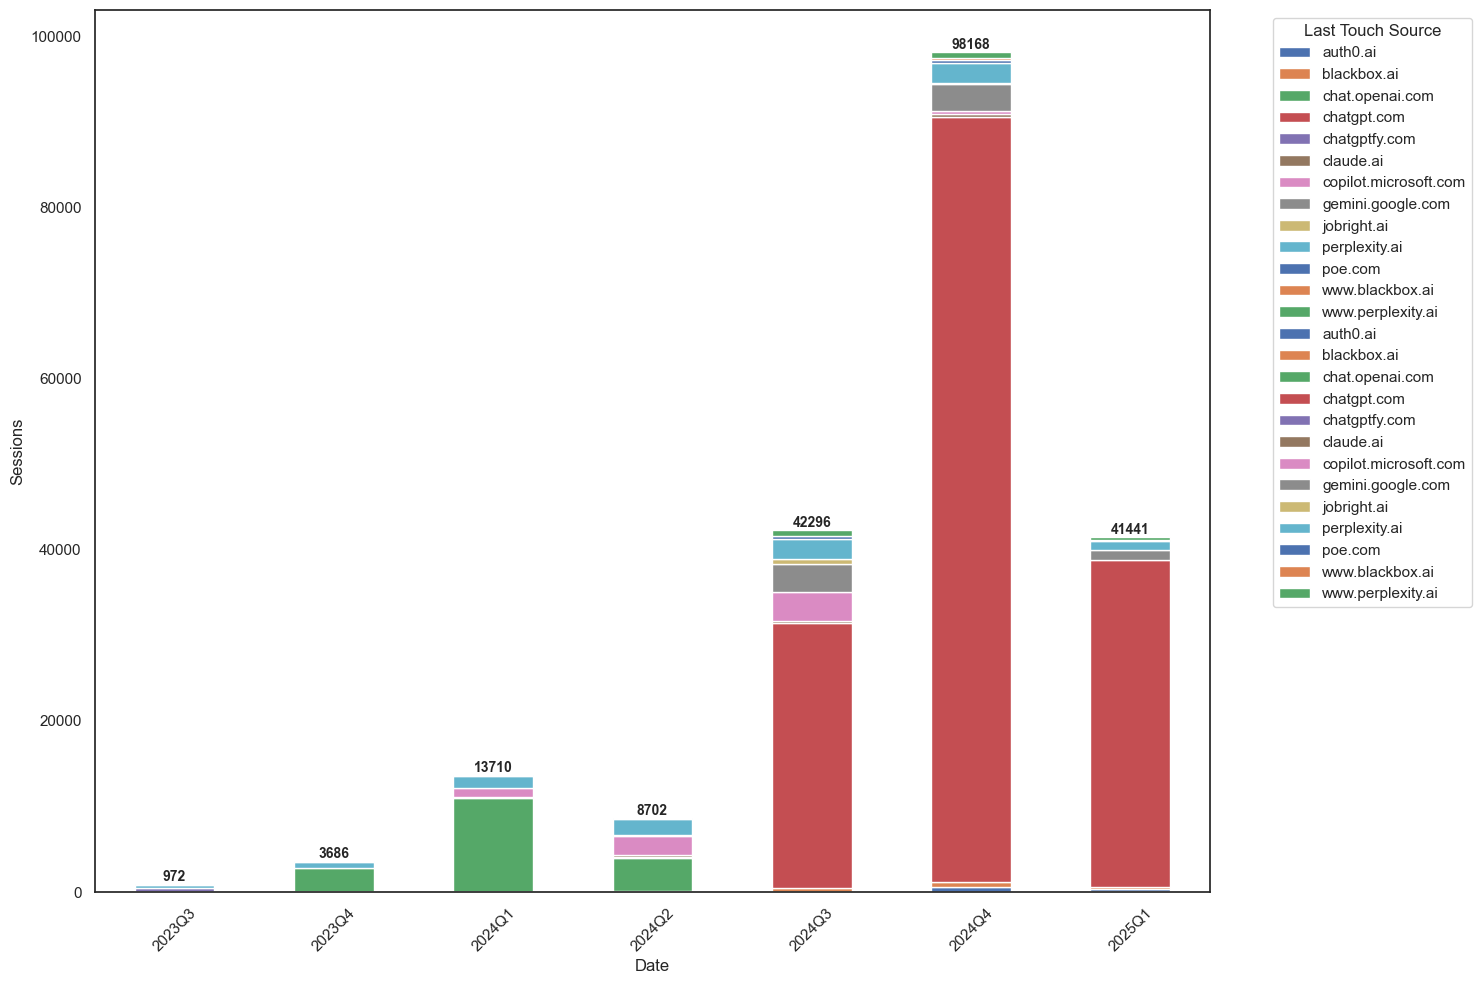

In [110]:
custom_colors = sns.color_palette("deep", n_colors=len(pivot_df.columns))

fig, ax = plt.subplots(figsize=(15, 10))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax)

bars = pivot_df.plot(kind='bar', stacked=True, ax=ax ,color=custom_colors)

for i, index in enumerate(pivot_df.index):
    total_value = pivot_df.loc[index].sum()
    ax.text(i, total_value, f"{int(total_value)}", ha='center', va='bottom', fontsize=10, fontweight='bold')
    
plt.xlabel("Date")
plt.ylabel("Sessions")
plt.legend(title="Last Touch Source", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Mapping URL

In [11]:
mapping_file_path = '/Users/vlad/Downloads/url_inventory.csv'

In [12]:
mapping_df = pd.read_csv(file_path)

In [20]:
for col in mapping_df.columns:
    print(f"* {col}")

* AEM Status
* (Temp) Status
* Global Retirement Flag
* Country
* AEM Category
* AEM Sub Category
* AEM URL
* Live "Cutover Date"
* AEM - Locale & Language
* Link to Content (Drupal)
* Redirect URL
* Page Views
(12/1/23-11/30/24)
* Gated?
* Page Status
* Title (Drupal)
* Content type (Drupal)
* Status (Drupal)
* Date Last Updated (Drupal)
* Translation source (Drupal)
* Translation language {Drupal)
* Is Headless (Drupal)
* To check
* Comments


In [14]:
mapping_df.head(5)

,AEM Status,(Temp) Status,Global Retirement Flag,Country,AEM Category,AEM Sub Category,AEM URL,"Live ""Cutover Date""",AEM - Locale & Language,Link to Content (Drupal),...,Page Status,Title (Drupal),Content type (Drupal),Status (Drupal),Date Last Updated (Drupal),Translation source (Drupal),Translation language {Drupal),Is Headless (Drupal),To check,Comments
0,Unpublished,NaN,Yes,us,NaN,NaN,NaN,NaN,NaN,https://www.okta.com/developer/,...,NaN,Developer homepage,[Developer] Page,Unpublished,9/2020,Not specified,United States,NaN,False,NaN
1,Unpublished,NaN,NaN,us,Resources,Analyst research,NaN,NaN,NaN,https://www.okta.com/analyst-research-forreste...,...,403.0,Forrester Report October 2016: The Future of I...,Analyst research,Unpublished,12/2022,Not specified,United States,NaN,False,NaN
2,Proposed for migration,NaN,NaN,au,Resources,Analyst research,NaN,NaN,NaN,https://www.okta.com/au/resources/access-manag...,...,200.0,Gartner® Magic Quadrant™for Access Management ...,Analyst research,Published,1/2024,United States,Australia,NaN,False,NaN
3,Unpublished,NaN,NaN,au,Resources,Analyst research,NaN,NaN,NaN,https://www.okta.com/au/resources/analyst-rese...,...,403.0,2023 IDC report: How IT can create a better em...,Analyst research,Unpublished,3/2024,United States,Australia,NaN,False,NaN
4,Proposed for migration,NaN,NaN,au,Resources,Analyst research,NaN,NaN,NaN,https://www.okta.com/au/resources/analyst-rese...,...,200.0,CIAM: Optimise Digital Experiences,Analyst research,Published,4/2024,United States,Australia,NaN,False,NaN


In [16]:
staus_unique_val = mapping_df['AEM Status'].unique()
staus_unique_val

array(['Unpublished', 'Proposed for migration', 'Approved for retirement',
       'Proposed for retirement', 'To confirm', 'Live',
       'Approved for Migration', 'Migrated but not live'], dtype=object)

In [22]:
pre_filtered_df = mapping_df.loc[mapping_df['AEM Status'].isin(['Live']),['AEM Status', 'AEM URL', 'Link to Content (Drupal)']]
pre_filtered_df.head(5)

,AEM Status,AEM URL,Link to Content (Drupal)
4312,Live,https://www.okta.com/en-au/customers/activ/,https://www.okta.com/au/customers/activ/
4316,Live,https://www.okta.com/en-au/customers/aia-group/,https://www.okta.com/au/customers/aia-group/
4317,Live,https://www.okta.com/en-au/customers/albertsons/,https://www.okta.com/au/customers/albertsons/
4319,Live,https://www.okta.com/en-au/customers/ames-aust...,https://www.okta.com/au/customers/ames-australia/
4320,Live,https://www.okta.com/en-au/customers/athenahea...,https://www.okta.com/au/customers/athenahealth/


In [24]:
new_col_order = ['Link to Content (Drupal)','AEM URL', 'AEM Status']
pre_filtered_df = pre_filtered_df.reindex(columns=new_col_order)
pre_filtered_df.head(5)

,Link to Content (Drupal),AEM URL,AEM Status
4312,https://www.okta.com/au/customers/activ/,https://www.okta.com/en-au/customers/activ/,Live
4316,https://www.okta.com/au/customers/aia-group/,https://www.okta.com/en-au/customers/aia-group/,Live
4317,https://www.okta.com/au/customers/albertsons/,https://www.okta.com/en-au/customers/albertsons/,Live
4319,https://www.okta.com/au/customers/ames-australia/,https://www.okta.com/en-au/customers/ames-aust...,Live
4320,https://www.okta.com/au/customers/athenahealth/,https://www.okta.com/en-au/customers/athenahea...,Live


In [27]:
# Trim leading and trailing spaces
pre_filtered_df = pre_filtered_df.apply(
    lambda col: col.str.strip() if col.dtype =="object" else col
)

In [33]:
pre_filtered_df.head(5)

,old_url,new_url,status
4312,https://www.okta.com/au/customers/activ/,https://www.okta.com/en-au/customers/activ/,Live
4316,https://www.okta.com/au/customers/aia-group/,https://www.okta.com/en-au/customers/aia-group/,Live
4317,https://www.okta.com/au/customers/albertsons/,https://www.okta.com/en-au/customers/albertsons/,Live
4319,https://www.okta.com/au/customers/ames-australia/,https://www.okta.com/en-au/customers/ames-aust...,Live
4320,https://www.okta.com/au/customers/athenahealth/,https://www.okta.com/en-au/customers/athenahea...,Live


In [32]:
pre_filtered_df.rename(columns = {"Link to Content (Drupal)":"old_url", "AEM URL":"new_url","AEM Status":"status"}, inplace=True)

In [35]:
dq1_df = pre_filtered_df[pre_filtered_df['old_url'].isna()]
dq1_df

,old_url,new_url,status
30523,NaN,https://www.okta.com/customers/mantech/,Live
30524,NaN,https://www.okta.com/customers/bloomerang/,Live
30525,NaN,https://www.okta.com/customers/moniflo/,Live
30526,NaN,https://www.okta.com/customers/cebu-pacific/,Live
30527,NaN,https://www.okta.com/customers/vibrant-emotion...,Live
...,...,...,...
31292,NaN,https://www.okta.com/webinars/hub/navigating-t...,Live
31293,NaN,https://www.okta.com/webinars/hub/the-value-of...,Live
31294,NaN,https://www.okta.com/webinars/hub/oktane-previ...,Live
31295,NaN,https://www.okta.com/webinars/hub/best-of-devd...,Live


In [36]:
dq2_df = pre_filtered_df[pre_filtered_df['new_url'].isna()]
dq2_df

,old_url,new_url,status


In [38]:
filtered_df = pre_filtered_df.dropna(subset=['old_url']) 
filtered_df.head(5)

,old_url,new_url,status
4312,https://www.okta.com/au/customers/activ/,https://www.okta.com/en-au/customers/activ/,Live
4316,https://www.okta.com/au/customers/aia-group/,https://www.okta.com/en-au/customers/aia-group/,Live
4317,https://www.okta.com/au/customers/albertsons/,https://www.okta.com/en-au/customers/albertsons/,Live
4319,https://www.okta.com/au/customers/ames-australia/,https://www.okta.com/en-au/customers/ames-aust...,Live
4320,https://www.okta.com/au/customers/athenahealth/,https://www.okta.com/en-au/customers/athenahea...,Live


In [43]:
filtered_df.to_csv('/Users/vlad/Downloads/mapping.csv', header=False, index=False)

In [45]:
filtered_df['old_url'].size

733

### Export to CSV

In [75]:
final_df= filtered_df[['old_url', 'new_url']]
final_df.to_csv('/Users/vlad/Downloads/mapping.csv', index=False)

In [40]:
dq3_df = filtered_df[filtered_df['old_url'].isna()]
dq3_df

,old_url,new_url,status


In [41]:
duplicates_mask = filtered_df.duplicated()
print(duplicates_mask)

4312     False
4316     False
4317     False
4319     False
4320     False
         ...  
23819    False
23820    False
23822    False
23824    False
23826    False
Length: 733, dtype: bool


## Merged mapping

In [76]:
file_path_1 = '/Users/vlad/Downloads/r2_product_redirects.csv'
file_path_2 = '/Users/vlad/Downloads/mapping.csv'

In [77]:
df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)

In [78]:
df_merged = pd.concat([df1, df2], axis=0, ignore_index=True)

In [79]:
df_merged.drop_duplicates(inplace=True)

In [80]:
df_merged['old_url'].size

1105

In [81]:
df_merged

,old_url,new_url
0,www.okta.com/de/fastpass/,www.okta.com/de-de/products/fastpass/
1,www.okta.com/de/platform/workflows/,www.okta.com/de-de/products/workflows/
2,www.okta.com/de/products/access-gateway/,www.okta.com/de-de/products/access-gateway/
3,www.okta.com/de/products/adaptive-multi-factor...,www.okta.com/de-de/products/adaptive-multi-fac...
4,www.okta.com/de/products/advanced-server-access/,www.okta.com/de-de/products/advanced-server-ac...
...,...,...
1102,https://www.okta.com/uk/products/release-overv...,https://www.okta.com/en-gb/products/release-ov...
1103,https://www.okta.com/uk/products/secure-partne...,https://www.okta.com/en-gb/products/secure-par...
1104,https://www.okta.com/uk/products/single-sign-on/,https://www.okta.com/en-gb/products/single-sig...
1105,https://www.okta.com/uk/products/universal-dir...,https://www.okta.com/en-gb/products/universal-...


In [82]:
df_merged.to_csv('/Users/vlad/Downloads/merged_file.csv', index=False)

## DQ Export

In [1]:
import pandas as pd

In [2]:
file_path = '/Users/vlad/Downloads/to_snowflake_pageviews_from_inquiries_20250113_pageviews_000000000000'

In [3]:
df_inc = pd.read_parquet(file_path)

In [4]:
df_inc.head(5)

,fullVisitorId,visitNumber,session_id,visitId,clientId,date,tab_id,ts,hitNumber,hit_id,...,next_page_ts,is_entrance,is_exit,seconds_on_page,is_bounce,scroll_depth,hit_type,campaign_member_id,inquiry_date,dbt_run_ts
0,3622307275202931709,1,94bd5495c4fc322e50b4363875bc4c23,1707650045,843384134.1707650045,2024-02-11,70866caa-d0c8-4272-a62b-3deccf52c7b3,2024-02-11 03:14:05.144,2,a87aa2ea9328d057f9764ebfc6a26cd5,...,2024-02-11 03:14:16.232,True,False,11,False,50,Pageview,00v4z00004fMwc2AAC,2024-02-11,2024-09-06 00:29:57
1,3312771352990118799,101,d8609c9cdf738167c26b484c2b4d2a89,1700614644,771314686.1695609743,2023-11-21,b615dc98-19f5-49a3-9a50-6c7abd7edcca,2023-11-21 16:58:42.314,36,ee6d0342dcdcd0945ed8a42a58977064,...,2023-11-21 16:59:22.887,False,False,40,False,25,Pageview,00v4z00004fMxVZAA0,2024-02-11,2024-09-06 00:29:57
2,7335741007218536377,523,11e37ce663fed301dd77ca94ff204836,1716335509,1707985300.1669787577,2024-05-21,3b79db96-712b-4d1a-a6ef-9f20503c0d47,2024-05-21 16:54:24.435,33,6a769b2966979c5a170919555ed21bdd,...,NaT,False,True,0,False,100,Pageview,00v4z00004fMxZbAAK,2024-02-11,2024-09-06 00:29:57
3,7335741007218536377,523,11e37ce663fed301dd77ca94ff204836,1716335509,1707985300.1669787577,2024-05-21,3b79db96-712b-4d1a-a6ef-9f20503c0d47,2024-05-21 16:54:24.435,33,6a769b2966979c5a170919555ed21bdd,...,NaT,False,True,0,False,100,Pageview,00v4z00004fMxkMAAS,2024-02-11,2024-09-06 00:29:57
4,3312771352990118799,44,f8916684ae5c6e1e672ab5387cc5e3df,1697591823,771314686.1695609743,2023-10-17,39f87a7c-e6db-4062-9d38-e1a7f7fd107e,2023-10-17 18:17:03.038,3,c399a13c6e520838aaa95c990d942794,...,2023-10-17 18:41:35.505,True,False,1472,False,25,Pageview,00v4z00004fMxVZAA0,2024-02-11,2024-09-06 00:29:57


In [5]:
for col in df_inc.columns:
    print(col)

fullVisitorId
visitNumber
session_id
visitId
clientId
date
tab_id
ts
hitNumber
hit_id
url
url_anchor
hostname
site_locale
page_section
full_page_path
previous_page_hit_id
next_page_hit_id
previous_page
next_page
next_page_ts
is_entrance
is_exit
seconds_on_page
is_bounce
scroll_depth
hit_type
campaign_member_id
inquiry_date
dbt_run_ts


In [12]:
df_inc.head(5)

,page_url,page_hostname,search_query,is_branded_search,is_anonymized_query,country_name,search_type,device_type,impressions,clicks,...,url,is_branded_landing_page,country,region,sub_region,site_content_section,category,is_qualified_session,export_timestamp,batch_id


In [5]:
df_inc[['session_id', 'is_conversion', 'traffic_source_name', 'page_path']]

,session_id,is_conversion,traffic_source_name,page_path


In [1]:
import pandas as pd

In [2]:
file_path = '/Users/vlad/Downloads/r2_product_redirects.csv'

In [3]:
df_file = pd.read_csv(file_path)

In [4]:
df_file.head(5)

,old_url,new_url
0,www.okta.com/de/products/authentication/,www.okta.com/de-de/products/authentication/
1,www.okta.com/de/products/authentication,www.okta.com/de-de/products/authentication/
2,www.okta.com/de/customer-identity/authentication/,www.okta.com/de-de/products/authentication-cus...
3,www.okta.com/de/customer-identity/authentication,www.okta.com/de-de/products/authentication-cus...
4,www.okta.com/au/products/authentication/,www.okta.com/en-au/products/authentication/


In [3]:
from google.cloud import bigquery
import pandas as pd

In [11]:
project_id = 'okta-ga-rollup'

In [20]:
import csv

In [25]:
data = [
  {'date': {'name': 'date',
  'description': '',
  'type': 'DATE',
  'mode': 'NULLABLE'},
 'country': {'name': 'country',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'state': {'name': 'state',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'metro': {'name': 'metro',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'city': {'name': 'city',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_channel': {'name': 'first_touch_channel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_source': {'name': 'first_touch_source',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_medium': {'name': 'first_touch_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_source_medium': {'name': 'first_touch_source_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_campaign': {'name': 'first_touch_campaign',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_channel': {'name': 'last_touch_channel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_source': {'name': 'last_touch_source',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_medium': {'name': 'last_touch_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_source_medium': {'name': 'last_touch_source_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_campaign': {'name': 'last_touch_campaign',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_channel': {'name': 'last_non_direct_channel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_source': {'name': 'last_non_direct_source',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_medium': {'name': 'last_non_direct_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_source_medium': {'name': 'last_non_direct_source_medium',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_campaign': {'name': 'last_non_direct_campaign',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'business_unit': {'name': 'business_unit',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'landing_page': {'name': 'landing_page',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'page_hostname': {'name': 'page_hostname',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'user_type': {'name': 'user_type',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'has_null_user_pseudo_id': {'name': 'has_null_user_pseudo_id',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'device_screen_resolution': {'name': 'device_screen_resolution',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'device_viewport_resolution': {'name': 'device_viewport_resolution',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'device_browser_version': {'name': 'device_browser_version',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'high_value_visit_had_conversion': {'name': 'high_value_visit_had_conversion',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'site_locale': {'name': 'site_locale',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'visitor_type': {'name': 'visitor_type',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'contained_auth0_blog_pageview': {'name': 'contained_auth0_blog_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_auth0_learn_pageview': {'name': 'contained_auth0_learn_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_auth0_docs_pageview': {'name': 'contained_auth0_docs_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_auth0_quickstarts_pageview': {'name': 'contained_auth0_quickstarts_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_sec_prop_pageview': {'name': 'contained_sec_prop_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'had_login_click': {'name': 'had_login_click',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_support_signon': {'name': 'contained_support_signon',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'digital_property': {'name': 'digital_property',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'is_qualified_session': {'name': 'is_qualified_session',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_www_pageview': {'name': 'contained_www_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'contained_auth0_pageview': {'name': 'contained_auth0_pageview',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'high_value_visit_had_2_pageviews': {'name': 'high_value_visit_had_2_pageviews',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'high_value_visit_had_30_engaged_seconds': {'name': 'high_value_visit_had_30_engaged_seconds',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'is_high_value_visit': {'name': 'is_high_value_visit',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'first_touch_subchannel': {'name': 'first_touch_subchannel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_subchannel': {'name': 'last_touch_subchannel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_subchannel': {'name': 'last_non_direct_subchannel',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'first_touch_channel_category': {'name': 'first_touch_channel_category',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_channel_category': {'name': 'last_touch_channel_category',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_non_direct_channel_category': {'name': 'last_non_direct_channel_category',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'engaged_sessions': {'name': 'engaged_sessions',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'single_page_sessions': {'name': 'single_page_sessions',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'engagement_time': {'name': 'engagement_time',
  'description': '',
  'type': 'FLOAT',
  'mode': 'NULLABLE'},
 'total_seconds': {'name': 'total_seconds',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'total_pageviews': {'name': 'total_pageviews',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'users': {'name': 'users',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'device_category': {'name': 'device_category',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'device_operating_system': {'name': 'device_operating_system',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'device_browser': {'name': 'device_browser',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'distinct_hostnames': {'name': 'distinct_hostnames',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_referrer': {'name': 'last_touch_referrer',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'last_touch_platform': {'name': 'last_touch_platform',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'impressions_branded_search': {'name': 'impressions_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'impressions_non_branded_search': {'name': 'impressions_non_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'impressions_total': {'name': 'impressions_total',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'clicks_branded_search': {'name': 'clicks_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'clicks_non_branded_search': {'name': 'clicks_non_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'clicks_total': {'name': 'clicks_total',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'sum_position_branded_search': {'name': 'sum_position_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'sum_position_non_branded_search': {'name': 'sum_position_non_branded_search',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'sum_position_total': {'name': 'sum_position_total',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'last_touch_is_branded_landing_page': {'name': 'last_touch_is_branded_landing_page',
  'description': '',
  'type': 'BOOLEAN',
  'mode': 'NULLABLE'},
 'data_source': {'name': 'data_source',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'conversions': {'name': 'conversions',
  'description': '',
  'type': 'RECORD',
  'mode': 'REPEATED'},
 'raw_sessions': {'name': 'raw_sessions',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'sessions': {'name': 'sessions',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'high_value_visits': {'name': 'high_value_visits',
  'description': '',
  'type': 'INTEGER',
  'mode': 'NULLABLE'},
 'landing_page_section': {'name': 'landing_page_section',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'region': {'name': 'region',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'},
 'sub_region': {'name': 'sub_region',
  'description': '',
  'type': 'STRING',
  'mode': 'NULLABLE'}}
]

In [26]:
# Export to CSV
csv_filename = 'bigquery_table_schema.csv'

In [27]:
with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['name', 'description', 'type', 'mode']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for item, item_info in data[0].items():
        writer.writerow({
            'name': item_info['name'],
            'description': item_info['description'],
            'type': item_info['type'],
            'mode': item_info['mode']
        })
print(f"CSV file '{csv_filename}' has been created.")

CSV file 'bigquery_table_schema.csv' has been created.


In [28]:
for k,v in data[0].items():
    print(v['name'])

date
country
state
metro
city
first_touch_channel
first_touch_source
first_touch_medium
first_touch_source_medium
first_touch_campaign
last_touch_channel
last_touch_source
last_touch_medium
last_touch_source_medium
last_touch_campaign
last_non_direct_channel
last_non_direct_source
last_non_direct_medium
last_non_direct_source_medium
last_non_direct_campaign
business_unit
landing_page
page_hostname
user_type
has_null_user_pseudo_id
device_screen_resolution
device_viewport_resolution
device_browser_version
high_value_visit_had_conversion
site_locale
visitor_type
contained_auth0_blog_pageview
contained_auth0_learn_pageview
contained_auth0_docs_pageview
contained_auth0_quickstarts_pageview
contained_sec_prop_pageview
had_login_click
contained_support_signon
digital_property
is_qualified_session
contained_www_pageview
contained_auth0_pageview
high_value_visit_had_2_pageviews
high_value_visit_had_30_engaged_seconds
is_high_value_visit
first_touch_subchannel
last_touch_subchannel
last_non_dir